**Imports and global delcarations**

In [1]:
# Hoang-Nam Tran, z5629534
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, precision_score, mean_absolute_error
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import r_regression
import csv


# Data columns before pre-processing
# ['year', 'month', 'u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z', 'SPI', 'grid_ID']

# Data columns after pre-processing
# ['year', 'month', 'u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z', 'SPI', 'grid_ID','Drought', 'monthCos', 'monthSin']
# monthCos and monthSin are the cosine and sine of the normalised month, respectively
allPredictors = ['year', 'month', 'u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z', 'SPI', 'grid_ID', 'Drought', 'monthCos', 'monthSin']

# forbidden indices: year, SPI, grid_ID, Drought -> 0, 14, 15, 16
forbiddenColumns = [0, 14, 15, 16]

#seed for reproducibility
shuffleSeed = 42

#seeding keras for reproducibility of training
keras.utils.set_random_seed(42)


**Method declarations for pre-processing**

In [2]:
# Initializing drought variable based on SPI (index 14)
def drought(data):
    for x in data:
        try:
            if float(x[14]) <= -1:
                x.append(1)
            else:
                x.append(0)
        except:
            #will occur in the first row only, as the first row is the column names
            x.append('Drought')
    return data


#removing rows with non-numerical values
def checkNonFloatNonNP(data):
    for x in data:
        for y in x:
            try:
                float(y)
            except:
                data.remove(x)
                break


#removing rows containing invalid months
def filterInvalidMonthsNP(data):
    new_data = []
    validMonths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    for x in data:
        if x[1] in validMonths:
            new_data.append(x)
    return np.array(new_data)


#normalising months, cyclic encoding with sin and cos
def normaliseMonth(dataSet):
    new_dataSet = []
    for x in dataSet:
        month = x[1]
        month_normalised = 2 * np.pi * (month - 1) / 12
        x = np.append(x, [np.cos(month_normalised), np.sin(month_normalised)])
        new_dataSet.append(x)
    return np.array(new_dataSet)


#removing rows with infinite values
def noIncludeInfinites(data):
    new_data = []
    detected = False
    for x in data:
        for y in x:
            if y == float('inf') or y == float('-inf'):
                detected = True
                break
        if detected == False:
            new_data.append(x)
    return np.array(new_data)


#detecting outliers (column-wise) with z-score method, threshold = 3
def detectOutliersByColumn(data, column):
    mean = np.mean(data[:, column])
    std_dev = np.std(data[:, column])
    z_scores = (data[:, column] - mean) / std_dev
    outliers = np.abs(z_scores) > 3
    outlier_indices = np.where(outliers)
    return outlier_indices


#removing rows with outliers
def removeOutliers(data, excludedColumns):
    outliersIndices = set()
    
    for i in range(0, len(data[0])):
        #excluding the forbidden columns
        if i not in excludedColumns:
            outlierIndicesColumn = detectOutliersByColumn(data, i)
            for x in outlierIndicesColumn[0]:
                outliersIndices.add(x)

    outliersIndices = list(outliersIndices)
    outliersIndices.sort()
    data = np.delete(data, outliersIndices, axis=0)
    return data

**Method declarations for evaluation**

In [3]:
#3f, Create a plot showing the accuracy (y-axis) versus the number of epochs (x-axis) for both the training and validation sets.
def plot_accuracy(result):
    plt.plot(result.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(result.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


#4e, Creating a plot showing the loss value (y-axis) versus the number of epochs (x-axis) for both the training and validation sets.
def plot_loss(result):
    plt.plot(result.history['loss'], 'b', label='Training loss')
    plt.plot(result.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#Create a scatter plot showing predicted SPI (y-axis) versus true SPI (x-axis)
def scatterPlot(target, predicted):
    plt.scatter(target, predicted)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('SPI vs Predicted SPI')
    plt.show()


#Compute and plot a confusion matrix. Positive class is 1, i.e. ‘Drought’.
def plotSimpleConfusionMatrix(target, predicted):
    confusion_matrix = metrics.confusion_matrix(target, predicted)
    cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Drought", "Drought"])
    cmDisplay.plot()
    plt.show()

#Printing used predictors, selecting the predictors from allVariables based on the given indices
def printPredictorsSet(allVariables, indices):
    usedPredictors = []
    for x in indices:
        usedPredictors.append(allVariables[x])
    print("Used predictors: ", usedPredictors)

**Calculating drought from SPI and pre-processing – 3a, 3c, 4b**

In [4]:
#uncomment from here to skip training

with open('Climate_SPI_Init.csv', newline='') as csvfileUnseen:
    initData = list(csv.reader(csvfileUnseen))

#pre-processing, adding drought variable, removing invalid rows
initData = drought(initData)
checkNonFloatNonNP(initData)

#shuffling the data for randomness in training
random.Random(shuffleSeed).shuffle(initData)

initData = np.array(initData)
initData = initData.astype(float)


#removing outliers, invalid months, infinite values, normalising months
initData = removeOutliers(initData, forbiddenColumns)
initData = filterInvalidMonthsNP(initData)
initData = noIncludeInfinites(initData)
initData = normaliseMonth(initData)

#3h, 4g, testing different subsets of predictors
# inputColumns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18]
# inputColumns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18]
# inputColumns = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
#inputColumns = [4, 6, 7, 8, 10, 11, 12, 13]


#predictors used for training and prediction
inputColumns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]

#selecting correct columns for input data
dataInput = initData[:, inputColumns]


#selecting target-columns for classification and regression, Drought (index 16) and SPI (index 14)
dataTargetClassification = initData[:, 16]
dataTargetRegression = initData[:, 14]

#normalising the input data with min-max normalisation
scaler = MinMaxScaler()
scaler.fit(dataInput)
dataInputNormalized = scaler.transform(dataInput)


**Splitting data into training (70%), validation (15%) and test sets (15%) – 3b, 4a**

In [5]:
#Data was shuffled before

#Split data by selecting correct rows for training, validation and testing
inputTrain = dataInputNormalized[:int(0.7*len(initData))]
inputVal = dataInputNormalized[int(0.7*len(initData)):int(0.85*len(initData))]
inputTest = dataInputNormalized[int(0.85*len(initData)):]


targetTrainClass = dataTargetClassification[:int(0.7*len(initData))]
targetValClass = dataTargetClassification[int(0.7*len(initData)):int(0.85*len(initData))]
targetTestClass = dataTargetClassification[int(0.85*len(initData)):]


targetRegression = dataTargetRegression[:int(0.7*len(initData))]
targetValRegression = dataTargetRegression[int(0.7*len(initData)):int(0.85*len(initData))]
targetTestRegression = dataTargetRegression[int(0.85*len(initData)):]

**Building and training the classification model – 3d, 3e**

**Plot of the accuracy (y-axis) versus the number of epochs (x-axis) for both the training and validation sets – 3f**

Epoch 1/200


/opt/anaconda3/envs/assignment1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7532 - loss: 0.5175 - val_accuracy: 0.8502 - val_loss: 0.4037
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8458 - loss: 0.4037 - val_accuracy: 0.8502 - val_loss: 0.3791
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.8462 - loss: 0.3779 - val_accuracy: 0.8520 - val_loss: 0.3641
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.8484 - loss: 0.3622 - val_accuracy: 0.8538 - val_loss: 0.3563
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8532 - loss: 0.3529 - val_accuracy: 0.8552 - val_loss: 0.3514
Epoch 6/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.8556 - loss: 0.3465 - val_accuracy: 0.8584 - val_loss: 0.3477
Epoch 7/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.8585 - loss: 0.3416 - val_accuracy: 0.8593 - val_loss: 0.3448
Epoch 8/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.8585 - loss: 0.3379 - val_

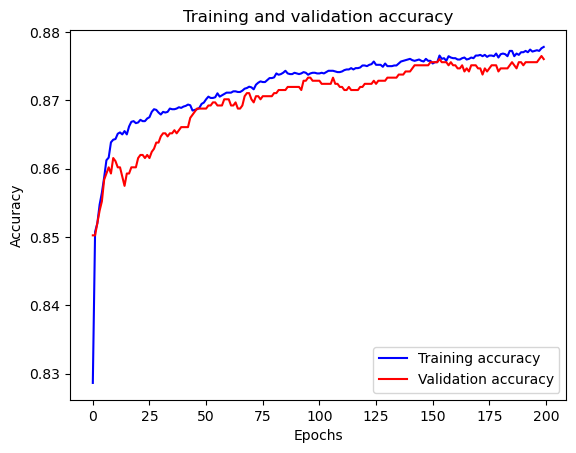

In [6]:
initClassModel = Sequential()
initClassModel.add(Dense(80, activation='relu', input_dim=14))
initClassModel.add(Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.001)
initClassModel.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
resultClass = initClassModel.fit(inputTrain, targetTrainClass, epochs=200, batch_size=64, validation_data=(inputVal, targetValClass))

plot_accuracy(resultClass)

**Building and training the regression model – 4c, 4d**

**A plot showing the loss value (y-axis) versus the number of epochs (x-axis) for both the training and validation sets – 4e**

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.9191 - mean_squared_error: 0.9191 - val_loss: 0.6682 - val_mean_squared_error: 0.6682
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.5890 - val_mean_squared_error: 0.5890
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.5937 - mean_squared_error: 0.5937 - val_loss: 0.5584 - val_mean_squared_error: 0.5584
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 0.5651 - mean_squared_error: 0.5651 - val_loss: 0.5411 - val_mean_squared_error: 0.5411
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.5484 - mean_squared_error: 0.5484 - val_loss: 0.5304 - val_mean_squared_error: 0.5304
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.5376 - mean_squared_error: 0.5376 - val_loss: 0.5232 - val_mean_squared_error: 0.5232
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.5299 - mean_squared_error: 0.

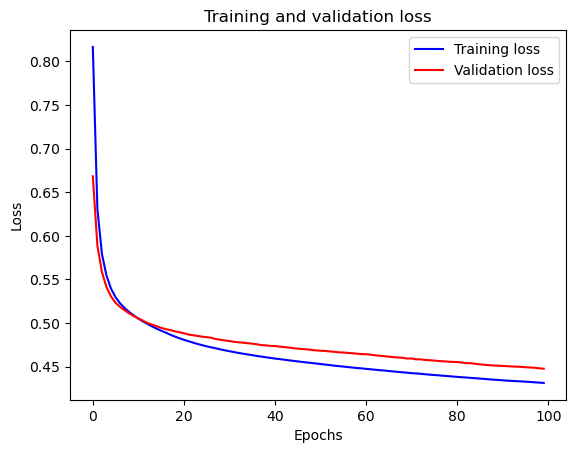

In [7]:
adamReg = keras.optimizers.Adam(learning_rate=0.001)
regressionModel = Sequential()

regressionModel.add(Dense(80, activation="relu", input_dim=14))
regressionModel.add(Dense(1))
regressionModel.compile(loss='mean_squared_error', optimizer=adamReg, metrics=["mean_squared_error"])
resultRegression = regressionModel.fit(inputTrain, targetRegression, epochs=100, batch_size=64, validation_data=(inputVal, targetValRegression))

plot_loss(resultRegression)

**Evaluating classification model on test set**

**Confusion matrix, performance metrics “Balanced Accuracy” and “Precision” calculated on the test set**

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


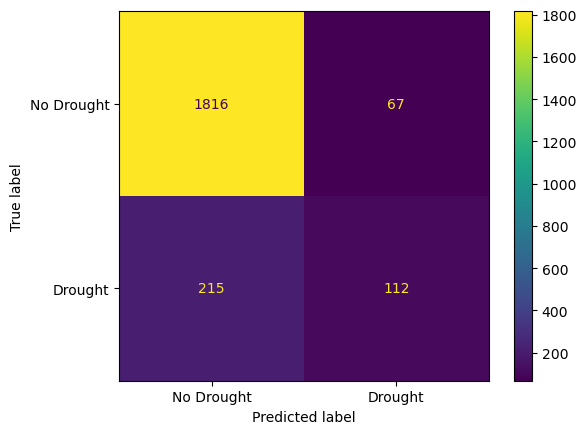

Balanced Accuracy:  0.6534630632035223
Precision:  0.6256983240223464


In [8]:
#predicting drought on the test set, binary classification with threshold 0.5
predictedClass = initClassModel.predict(inputTest)
predictedClassBinary = (predictedClass >= 0.5).astype("int32")


#plotting the confusion matrix and performance metrics
plotSimpleConfusionMatrix(targetTestClass, predictedClassBinary)
print("Balanced Accuracy: ", balanced_accuracy_score(targetTestClass, predictedClassBinary))
print("Precision: ", precision_score(targetTestClass, predictedClassBinary, pos_label=1))


**Evaluating regression model on test set**

**Scatter plot, “Mean Absolute Error (MAE)” and the “Pearson Correlation
Coefficient” between the true and predicted SPI**

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


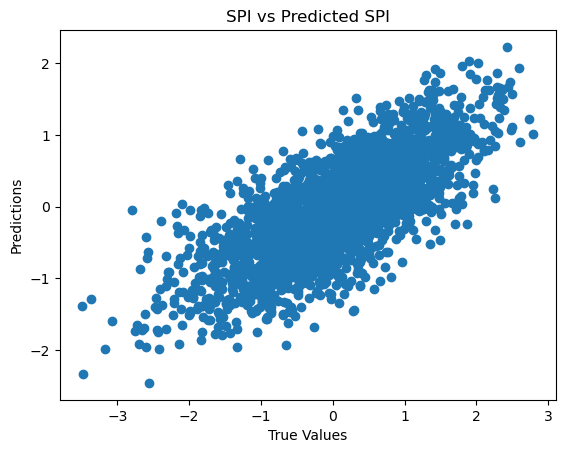

Mean Absolute Error:  0.5291525057053271
Pearson Correlation Coefficient:  [0.74259995]


In [9]:
#predicting SPI on the test set
predictedRegression = regressionModel.predict(inputTest)

#scatter plot and performance metrics
scatterPlot(targetTestRegression, predictedRegression)
print("Mean Absolute Error: ", mean_absolute_error(targetTestRegression, predictedRegression))
print("Pearson Correlation Coefficient: ", r_regression(predictedRegression, targetTestRegression))

**Saving models and loading saved models for task 5**

In [10]:
initClassModel.save("classificationDemo.keras")
regressionModel.save("regressionDemo.keras")

#uncomment until here to skip training

classificationModel = keras.models.load_model("classificationDemo.keras")
regressionModelLoaded = keras.models.load_model("regressionDemo.keras")

**Pre-processing unseen data**

In [11]:
# might need to change file name during discussion
with open('Fake_Climate_SPI6.csv', newline='') as csvfileUnseen:
    data = list(csv.reader(csvfileUnseen))

#pre-processing and normalisation of the unseen data with the same steps as on the previous data
data = drought(data)
checkNonFloatNonNP(data)

data = np.array(data)
data = data.astype(float)
data = removeOutliers(data, forbiddenColumns)
data = filterInvalidMonthsNP(data)
data = noIncludeInfinites(data)
data = normaliseMonth(data)


#selecting correct columns for input and target data, drought (index 16) and SPI (index 14)
dataInput = data[:, inputColumns]
dataTargetClassification = data[:, 16]
dataTargetRegression = data[:, 14]


#normalising the unseen input data with min-max normalisation
scaler = MinMaxScaler()
scaler.fit(dataInput)
dataInputNormalized = scaler.transform(dataInput)

**Predictions and evaluations on unseen data**

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Classification on unseen data


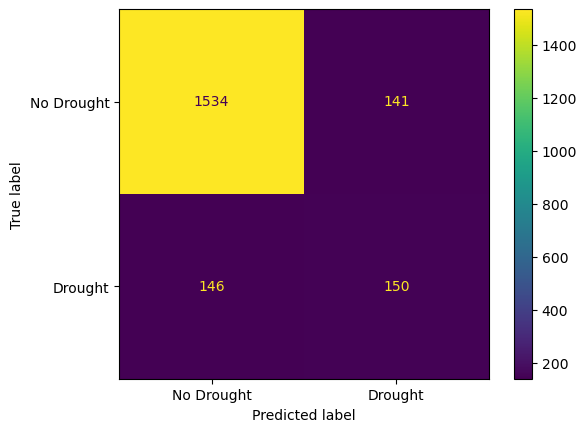

Balanced Accuracy:  0.7112888261395724
Precision:  0.5154639175257731
Number of samples:  1971
Used predictors:  ['u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z', 'monthCos', 'monthSin']
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Regression on unseen data


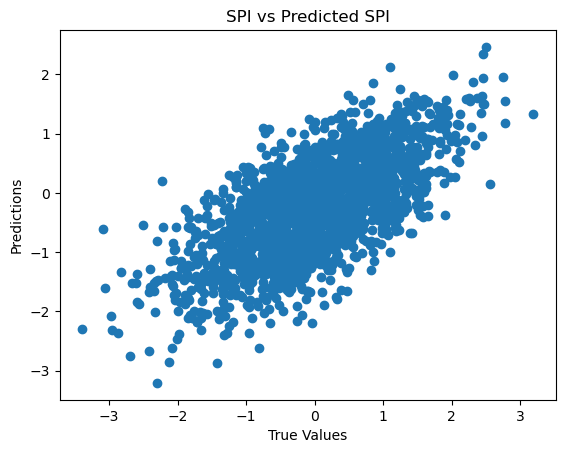

Mean Absolute Error:  0.6193055246115607
Pearson Correlation Coefficient:  [0.68880162]
Number of samples:  1971
Used predictors:  ['u10', 'v10', 'mx2t', 'mn2t', 'tcc', 't2', 'msl', 't', 'q', 'u', 'v', 'z', 'monthCos', 'monthSin']


In [12]:
#predicting drought, binary classification on unseen data, threshold 0.5
nClassificationPredicted = classificationModel.predict(dataInputNormalized)
nClassificationPredBin = (nClassificationPredicted >= 0.5).astype("int32")


#plotting the confusion matrix and performance metrics
print("Classification on unseen data")
plotSimpleConfusionMatrix(dataTargetClassification, nClassificationPredBin)
print("Balanced Accuracy: ", balanced_accuracy_score(
    dataTargetClassification, nClassificationPredBin))
print("Precision: ", precision_score(
    dataTargetClassification, nClassificationPredBin, pos_label=1))
print("Number of samples: ", len(data))
printPredictorsSet(allPredictors, inputColumns)


#predicting SPI on the unseen data
nRegressionPredicted = regressionModelLoaded.predict(dataInputNormalized)


#scatter plot and performance metrics
print("Regression on unseen data")
scatterPlot(dataTargetRegression, nRegressionPredicted)
print("Mean Absolute Error: ", mean_absolute_error(
    dataTargetRegression, nRegressionPredicted))
print("Pearson Correlation Coefficient: ", r_regression(
    nRegressionPredicted, dataTargetRegression))
print("Number of samples: ", len(data))
printPredictorsSet(allPredictors, inputColumns)
